# Predicting Grain Yields with a Pedigree-Based Reaction Norm GxE Model using the BGLR Package in R

From A Pedigree-Based Reaction Norm Model for Prediction of Cotton Yield in Multienvironment Trials

https://dl.sciencesocieties.org/publications/cs/abstracts/55/3/1143?access=0&view=pdf

## Install Necessary Packages and Mount Drive

In [0]:
# To host on a local runtime:
# Run the following from the command line or miniconda shell on your local machine:

# pip install jupyter_http_over_ws
# jupyter serverextension enable --py jupyter_http_over_ws

# conda create -n gxe_gee python=3.7 ipykernel jupyter anaconda
# conda activate gxe_gee
# ipython kernel install --name gxe_gee --user

# jupyter notebook \ --NotebookApp.allow_origin='https://colab.research.google.com' \ --port=8888 \ --NotebookApp.port_retries=0
jupyter notebook  --NotebookApp.allow_origin='https://colab.research.google.com'  --port=8888  --NotebookApp.port_retries=0


In [0]:
# Installing rpy2 package through Python to run R code

#!pip install rpy2

# If pip install doesn't work, try:

# !conda install -c r rpy2

# If the conda install line doesn't work, or if you have issues on your locally hosted runtime, try the following:
# https://anaconda.zendesk.com/hc/en-us/articles/360023857134-Setting-up-rpy2-on-Windows


^C


In [0]:
!pip install tzlocal
!pip install simplegeneric

In [0]:
# import necessary libraries in Python
import pandas as pd
import numpy as np
import os

In [0]:
# activate R magic
%load_ext rpy2.ipython

C:\Users\theaa\miniconda3\envs\gxe_gee\lib\site-packages\rpy2\robjects\pandas2ri.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [0]:
import rpy2
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

# import R's "base" package
base = importr('base')

# import rpy2's package module
import rpy2.robjects.packages as rpackages

# import R's utility package
utils = rpackages.importr('utils')

# select a mirror for R packages
utils.chooseCRANmirror(ind=1) # select the first mirror in the list

rpy2.rinterface.NULL

In [0]:
# Import the pandas2ri functions and activate
from rpy2.robjects import pandas2ri
pandas2ri.activate()

In [0]:
%%R # Install other R Packages
# May result in RunTimeWarnings, these can be ignored
install.packages('ggplot2')
install.packages('pedigreemm')
install.packages('dplyr')
install.packages('tidyverse')
install.packages('caret')
install.packages("mice")
install.packages("VIM")
install.packages('BGLR')

In [0]:
%%R 
require("ggplot2")
require("pedigreemm")
require("dplyr")
require('BGLR')
require('tidyverse')
require('caret')
require('mice')
require('VIM')

In [0]:
# Mount the Colab notebook in Google Drive
# Only if running from a hosted runtime in Colab, ignore if running locally

from google.colab import drive # import drive from google colab

drive.mount("/content/drive")  # mount the google drive at /content/drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Search for the root directory of the project in Drive and save as a path string

parent_dir_name = 'GxE with GEE'

for dirpath, subdirs, files in os.walk('/content'):
  if parent_dir_name in subdirs:
    parent_path = dirpath + "/" + parent_dir_name

parent_path

'/content/drive/My Drive/Research/GxE with GEE'

In [0]:
# Set Data Path
## Change the destination to your Drive directory containing the folder 'raw_data.zip'
data_path_end = '/Colab Workspace/Data'
data_path = parent_path + data_path_end
os.chdir(data_path)
os.getcwd()

'/content/drive/My Drive/Research/GxE with GEE/Colab Workspace/Data'

In [0]:
# Locally hosted version, just set the destination manually

data_path = 'C:/Users/theaa/Downloads'
os.chdir('C:/Users/theaa/Downloads')
os.getcwd()

'C:\\Users\\theaa\\Downloads'

In [0]:
%%R -i data_path
# Import the parent_path object from Python and use to set the R working directory
 setwd(data_path)

In [0]:
%%R
getwd()

## Processing Sample Data

From A Pedigree-Based Reaction Norm Model for Prediction of Cotton Yield in Multienvironment Trials

https://dl.sciencesocieties.org/publications/cs/abstracts/55/3/1143?access=0&view=pdf

### Description of Data Objects

* `Y`: data frame containing the elements described below;

  * `Y$grain_yield` (n×1), a numeric vector with centered and standardized yield;

  * `Y$VAR`  (n×1), a factor giving the IDs for the varieties;

  * `Y$ENV` (n×1), a factor giving the IDs for the environments (year-location);

* `A`: a symmetric positive semi-definite matrix containing the pedigree or marker-based relationships (dimensions equal to number of lines by number of lines). We assume that the `rownames(A)=colnames(A)` gives the IDs of the lines;

* `W`: a matrix containing the environmental covariates (n×q).


## Processing the Entire Dataset

### Import and Process CIMMYT Data

In [0]:
data = pd.read_pickle('proc_data.pkl')
data.columns=data.columns.str.upper()
data.head()

In [0]:
# Save Data from Python Environment to CSV
data['GRAIN_YIELD'] = pd.to_numeric(data['GRAIN YIELD'],errors='coerce')
data.drop_duplicates(subset=['UNIQUE_ID'],inplace=True)
data.dropna(subset=['GRAIN_YIELD'],inplace=True)
data.dropna(subset=['HARVEST_FINISHING_DATE'],inplace=True)
data.dropna(subset=['GENO_ID'],inplace=True)

data = data.astype(str)
data.to_csv('yield_data.csv')

In [0]:
%%R
# Import Data Objects to R Environment
# n is number of observations

data = read.csv('yield_data.csv', header = TRUE)
data = data.frame(lapply(data, as.character), stringsAsFactors=FALSE)
data[ data == "nan" ] <- NA
data[ data == "NaN" ] <- NA
data[ data == "NaT" ] <- NA
row.names(data) = data$UNIQUE_ID

nrow(data)

[1] 149529


In [0]:
%%R
# Import GID Numbers CSV
GID_CID_SID = read.csv('GID_Numbers.csv')

GID_CID_SID = data.frame(lapply(GID_CID_SID, as.character), stringsAsFactors=FALSE)
GID_CID_SID[ GID_CID_SID == "nan" ] <- NA
GID_CID_SID[ GID_CID_SID == "NaN" ] <- NA
GID_CID_SID[ GID_CID_SID == "NaT" ] <- NA

GID_CID_SID$GENO_ID = paste(GID_CID_SID$CID, "_", GID_CID_SID$SID, sep = "")

In [0]:
%%R
# Join Sample with GIDs by CID_SID
data_merge = merge(data, GID_CID_SID, by="GENO_ID", )
data_merge = data.frame(lapply(data_merge, as.character), stringsAsFactors=FALSE)
data_merge[ data_merge == "nan" ] <- NA
data_merge[ data_merge == "NaN" ] <- NA
data_merge[ data_merge == "NaT" ] <- NA
row.names(data_merge) = data_merge$UNIQUE_ID

nrow(data_merge)

[1] 145770


In [0]:
%%R
# Drop rows with missing data for yield, location, harvest timing
data_merge = data_merge[!is.na(data_merge$GRAIN_YIELD),]
data_merge = data_merge[!is.na(data_merge$LAT_COORD),]
data_merge = data_merge[!is.na(data_merge$LONG_COORD),]
data_merge = data_merge[!is.na(data_merge$HARVEST_FINISHING_DATE),]


In [0]:
%%R
# Identify missing IDs
Un_ID_missing = setdiff(rownames(data), rownames(data_merge))
length(Un_ID_missing)

[1] 4002


### Import A Matrix

In [0]:
%%R
# A : pedigree coefficient of parentage symmetric positive semi-definite matrix

# Rdata files don't seem to open properly in the Rpy2 environment
# Use the following commands in R to convert the Rdata to a csv

# A_raw = load('A_3k.RData')
# write.csv(A_raw, 'A_matrix.csv')

A = read.csv('A_matrix.csv', row.names = 1, header = TRUE)

In [0]:
%%R
# Remove the X prefix from the column names
names(A) <- substring(names(A),2)

# Get a list of unique GID values from the data
Unique_GID = c(unique(data_merge$GID))
length(Unique_GID)


[1] 3449


In [0]:
%%R
# Identify the GIDs which are present in the data but not the A matrix
GID_missing = setdiff(Unique_GID, rownames(A))
length(GID_missing)

[1] 6


In [0]:
%%R
# Remove the missing GID from the list of unique GIDs from the data sample
if (length(GID_missing) > 0) {
Unique_GID = Unique_GID[Unique_GID != GID_missing]
}  

length(Unique_GID)


[1] 3446


In [0]:
%%R
# Subset the A matrix to the list of GIDs in the data sample
A = A[Unique_GID,Unique_GID]

# Convert to a matrix
A = as.matrix(A)


R[write to console]: Error in `[.data.frame`(A, Unique_GID, Unique_GID) : 
  undefined columns selected
Calls: <Anonymous> -> <Anonymous> -> withVisible -> [ -> [.data.frame

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In Unique_GID != GID_missing :
R[write to console]: 
 
R[write to console]:  longer object length is not a multiple of shorter object length




Error in `[.data.frame`(A, Unique_GID, Unique_GID) : 
  undefined columns selected
Calls: <Anonymous> -> <Anonymous> -> withVisible -> [ -> [.data.frame


In [0]:
%%R
# Remove the missing GID values from the data sample
data_merge = data_merge[ ! data_merge$GID %in% GID_missing, ]
print(paste('The number of rows in the data sample is: ', nrow(data_merge)))
print(paste('The number of unique varieties by GID is: ', length(unique(data_merge$GID))))

[1] "The number of rows in the data sample is:  145348"
[1] "The number of unique varieties by GID is:  3443"


### Splitting into Yield and Environment Objects


In [0]:
%%R
# Yield Vector (nx1)
grain_yield = data_merge$GRAIN_YIELD
grain_yield = as.numeric(grain_yield)
grain_yield = standardize(grain_yield)
length(grain_yield)

[1] 145348


In [0]:
%%R
# Varieties (nx1)
VAR = data_merge$GID
VAR = as.numeric(VAR)


In [0]:
%%R
# Environments, meaning location-year combinations (nx1)
data_merge$LOC_YEAR = paste(data_merge$LAT_COORD, "_",
                            data_merge$LONG_COORD, "_", 
                            sapply(strsplit(data_merge$HARVEST_FINISHING_DATE,"-"), `[`, 1)
                            , sep = "")

ENV = data_merge$LOC_YEAR

In [0]:
%%R
Y = data.frame(grain_yield, VAR, ENV)
print(nrow(Y))
head(Y)

[1] 145348
  grain_yield     VAR               ENV
1       2.065 1395073  25.18_83.03_2003
2       5.764 1395073   36.13_59.4_2003
3       3.697 1395073 -23.22_-51.1_2003
4       2.993 1395073   36.5_68.55_2003
5       0.861 1395073  30.12_67.01_2003
6       3.435 1395073  36.38_66.56_2003


In [0]:
%%R
# Extract Environmental Covariates
env_cov_list = c('ALTITUDE',
'PPN_10TH_MO_BEFORE_HARVESTED',
'PPN_11TH_MO_BEFORE_HARVESTED',
'PPN_1ST_MO_BEFORE_HARVESTED',
'PPN_2ND_MO_BEFORE_HARVESTED',
'PPN_3RD_MO_BEFORE_HARVESTED',
'PPN_4TH_MO_BEFORE_HARVESTED',
'PPN_5TH_MO_BEFORE_HARVESTED',
'PPN_6TH_MO_BEFORE_HARVESTED',
'PPN_7TH_MO_BEFORE_HARVESTED',
'PPN_8TH_MO_BEFORE_HARVESTED',
'PPN_9TH_MO_BEFORE_HARVESTED',
'PPN_MONTH_OF_HARVESTED',
'PRECIPITATION_FROM_SOWING_TO_MATURITY',
#'SOIL_CLASIFICATION',
'TOTAL_PRECIPIT_IN_12_MONTHS',
'IRRIGATED'
#, 'PRE_SOWING_IRRIGATION'
)

W = data_merge[env_cov_list]
W = type.convert(W)

dmy = dummyVars(" ~ .", data = W)
W = data.frame(predict(dmy, newdata = W))

str(W)

'data.frame':	145348 obs. of  17 variables:
 $ ALTITUDE                             : num  128 985 540 403 1600 ...
 $ PPN_10TH_MO_BEFORE_HARVESTED         : num  NA NA 80 NA NA NA NA 4 92 NA ...
 $ PPN_11TH_MO_BEFORE_HARVESTED         : num  NA NA 82 NA NA NA NA 12 NA NA ...
 $ PPN_1ST_MO_BEFORE_HARVESTED          : num  NA NA 48 9 NA NA 25 93 77 5 ...
 $ PPN_2ND_MO_BEFORE_HARVESTED          : num  91 40 31 53 NA NA 49 67 28 23 ...
 $ PPN_3RD_MO_BEFORE_HARVESTED          : num  10 62 57 109 NA NA 145 73 24 78 ...
 $ PPN_4TH_MO_BEFORE_HARVESTED          : num  4 35 103 43 NA NA 10 NA 22 158 ...
 $ PPN_5TH_MO_BEFORE_HARVESTED          : num  NA 30 31 27 NA NA 17 15 7 103 ...
 $ PPN_6TH_MO_BEFORE_HARVESTED          : num  NA 30 150 NA NA NA NA 7 18 50 ...
 $ PPN_7TH_MO_BEFORE_HARVESTED          : num  NA 19 286 NA NA NA NA 3 115 75 ...
 $ PPN_8TH_MO_BEFORE_HARVESTED          : num  NA 22 67 NA NA NA NA 5 259 29 ...
 $ PPN_9TH_MO_BEFORE_HARVESTED          : num  NA 1 236 NA NA NA NA 7 38 


 Variables sorted by number of missings: 
                              Variable      Count
          PPN_11TH_MO_BEFORE_HARVESTED 0.79423865
          PPN_10TH_MO_BEFORE_HARVESTED 0.78170322
           PPN_9TH_MO_BEFORE_HARVESTED 0.76278999
                PPN_MONTH_OF_HARVESTED 0.75510499
           PPN_8TH_MO_BEFORE_HARVESTED 0.74525277
           PPN_7TH_MO_BEFORE_HARVESTED 0.72655970
           PPN_6TH_MO_BEFORE_HARVESTED 0.71291659
           PPN_1ST_MO_BEFORE_HARVESTED 0.70174340
           PPN_5TH_MO_BEFORE_HARVESTED 0.69912899
           PPN_4TH_MO_BEFORE_HARVESTED 0.68911853
           PPN_2ND_MO_BEFORE_HARVESTED 0.68845117
           PPN_3RD_MO_BEFORE_HARVESTED 0.68044968
           TOTAL_PRECIPIT_IN_12_MONTHS 0.58679858
 PRECIPITATION_FROM_SOWING_TO_MATURITY 0.58268432
                          IRRIGATED.NO 0.01954619
                         IRRIGATED.YES 0.01954619
                              ALTITUDE 0.00000000


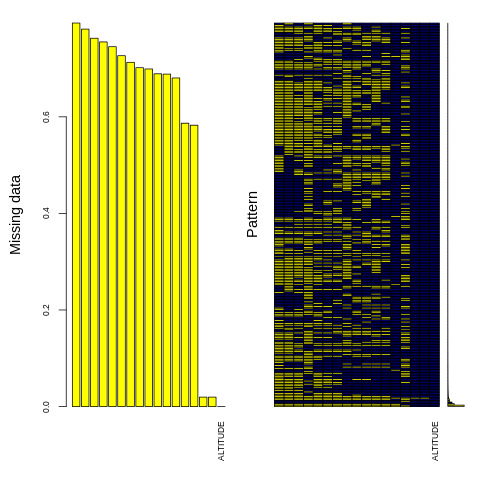

In [0]:
%%R
# Visualize missing data using mice_plot function
mice_plot <- aggr(W, col=c('navyblue','yellow'),
                    numbers=TRUE, sortVars=TRUE,
                    labels=names(W), cex.axis=.7,
                    gap=3, ylab=c("Missing data","Pattern"))

### Multiple Imputation by Chained Equations for Environment Data

In [0]:
%%R
# Hmisc method, doesn't work unless you spell out all the variables in the function.
# Potentially find a workaround

#install.packages("Hmisc")
#library(Hmisc)

#ivs = paste(env_cov_list,sep = "" )
#iv_string <- paste(ivs, collapse=" + ")
#iv_string[0]

#impute_arg <- aregImpute(as.formula(~iv_string), data = W, n.impute = 5)

In [0]:
%%R
# missForest function for imputation
# Seems to be the fastest and works non-parametrically

install.packages("missForest")
library(missForest)


In [0]:
%%R
W.imp <- missForest(W)

W.imp$OOBerror


In [0]:
%%R
W_imp <- W.imp$ximp
W <- W_imp

In [0]:
%%R
# Save after imputing missing values for W since the function takes a while
# Import the data again if you come back in another session

# write.csv(W, 'W_imp.csv')
#W <- read.csv('W_imp.csv')

In [0]:
%%R
# mice package for imputation, highly recommended but seems too slow for size of data
# https://www.analyticsvidhya.com/blog/2016/03/tutorial-powerful-packages-imputing-missing-values/

#W.imp <- mice(W, m=5, maxit = 15, method = 'pmm')
#summary(W.imp)


 iter imp variable
  1   1  PPN_10TH_MO_BEFORE_HARVESTED  PPN_11TH_MO_BEFORE_HARVESTED  PPN_1ST_MO_BEFORE_HARVESTED  PPN_2ND_MO_BEFORE_HARVESTED  PPN_3RD_MO_BEFORE_HARVESTED  PPN_4TH_MO_BEFORE_HARVESTED  PPN_5TH_MO_BEFORE_HARVESTED  PPN_6TH_MO_BEFORE_HARVESTED  PPN_7TH_MO_BEFORE_HARVESTED  PPN_8TH_MO_BEFORE_HARVESTED

From cffi callback <function _processevents at 0x7ffabdc139d8>:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/rpy2/rinterface_lib/callbacks.py", line 262, in _processevents
    @ffi_proxy.callback(ffi_proxy._processevents_def,
KeyboardInterrupt


  PPN_9TH_MO_BEFORE_HARVESTED  PPN_MONTH_OF_HARVESTED  PRECIPITATION_FROM_SOWING_TO_MATURITY

From cffi callback <function _processevents at 0x7ffabdc139d8>:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/rpy2/rinterface_lib/callbacks.py", line 262, in _processevents
    @ffi_proxy.callback(ffi_proxy._processevents_def,
KeyboardInterrupt


  TOTAL_PRECIPIT_IN_12_MONTHS  IRRIGATED.NO
  1   2  PPN_10TH_MO_BEFORE_HARVESTED  PPN_11TH_MO_BEFORE_HARVESTED  PPN_1ST_MO_BEFORE_HARVESTED

In [0]:
%%R
#W <- complete(W.imp,2)

In [0]:
%%R
# Standardize environmental data
W <- standardize(W)
W.head()

In [0]:
%%R
# Check that yield, variety, location, and environmental covariates are same length
print(paste('Yield vector length: ', length(Y$grain_yield)))
print(paste('Varieties vector length: ', length(Y$VAR)))
print(paste('Location-year vector length: ', length(Y$ENV)))
print(paste('Environmental covariates vector length: ', nrow(W)))

# Check that A Matrix contrains all unique varieties from the data
print(paste('Unique Varieties: ', length(unique(Y$VAR))))
print(paste('A Matrix length: ', nrow(A)))

[1] "Yield vector length:  145348"
[1] "Varieties vector length:  145348"
[1] "Location-year vector length:  145348"
[1] "Environmental covariates vector length:  145348"
[1] "Unique Varieties:  3443"
[1] "A Matrix length:  3489"


### Export Merged Data for Comparison

In [0]:
%%R
# Export the merged data for comparison
write.csv(data_merge, 'merged_data.csv')
write.csv(Y, 'pheno_yield_data.csv')
write.csv(W, 'environmental_covariates_data.csv')
write.csv(A, 'pedigree_data.csv')

## Import Data and Prep for Analysis

In [0]:
%%R
# Read data back in, only if you have already saved it in a previous session and have to come back
Y <- read.csv('pheno_yield_data.csv', row.names = 1)
W <- read.csv('environmental_covariates_data.csv', row.names = "X")
A <- read.csv('pedigree_data.csv', row.names = 1)

In [0]:
%%R
# A matrix doesn't read in well as a CSV, need to repeat some processing steps
# Remove the X prefix from the column names
names(A) <- substring(names(A),2)
print(colnames(A)[1])
print(rownames(A)[1])

In [0]:
%%R
# Get a list of unique GID values from the data
Unique_GID = c(unique(Y$VAR))
length(Unique_GID)


In [0]:
%%R
# Identify the GIDs which are present in the data but not the A matrix
#GID_missing = setdiff(Unique_GID, rownames(A))
GID_missing = setdiff(rownames(A), Unique_GID)
length(GID_missing)

In [0]:
%%R
# Remove the missing GID from the list of unique GIDs from the data sample
Unique_GID = Unique_GID[Unique_GID != GID_missing]
Unique_GID <- unlist(lapply(Unique_GID, as.character))
# Subset the A matrix to the list of GIDs in the data sample
A = A[Unique_GID,Unique_GID]
# Convert to a matrix
A = as.matrix(A)
nrow(A)

In [0]:
%%R
print(paste('Environmental covariates vector length: ', nrow(W)))
print(paste('Unique Varieties: ', length(unique(Y$VAR))))
print(paste('A Matrix length: ', nrow(A)))

## Run Model on Full Data

In [0]:
%%R
# Fitting Model 1 (Main Environment-Line Effects)
# (EL)

library('BGLR')

set.seed(123)
training.samples <- Y$grain_yield %>%
  createDataPartition(p = 0.8, list = FALSE)

y_train = Y$grain_yield
y_train[-training.samples] = NA

# incidence matrix for main eff. of environments.
ZE = model.matrix(~factor(Y$ENV)-1)     

# incidence matrix for main eff. of lines.
Y$VAR = factor(x=Y$VAR,levels=rownames(A),ordered=TRUE)
ZVAR = model.matrix(~Y$VAR-1)
	

In [0]:
%%R
# Model Fitting

ETA = list(ENV=list(X=ZE,model='BRR'),
           VAR=list(X=ZVAR,model='BRR'))
	
fm1 = BGLR(y=y_train,ETA=ETA,saveAt='M1_',nIter=500,burnIn=200)


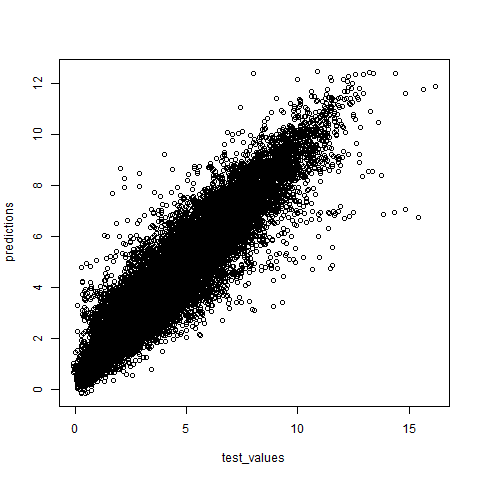

In [0]:
%%R
predictions = fm1$yHat[-training.samples]
test_values = Y$grain_yield[-training.samples]
R2 = R2(predictions, test_values)
RMSE = RMSE(predictions, test_values)
MAE = MAE(predictions, test_values)
model1_scores = data.frame(R2, RMSE, MAE)

plot(test_values,predictions)

In [0]:
%%R
# Alternative Model 2 with Eigendecomposition

L_star = eigen(A, symmetric =TRUE)
Gamma = L_star$vectors
Lambda = L_star$values 
Z_star = ZVAR%*%Gamma%*%(Lambda^0.5)

# Fitting Model 2 with Alternative Z_star (Main Environment-Pedigree Effects)
# (EA)

ETA = list(ENV=list(X=ZE,model='BRR'),
           PED=list(X=Z_star,model='BRR'))
	
fm2 = BGLR(y=y_train,ETA=ETA,saveAt='M2_',nIter=1000,burnIn=500)


In [0]:
%%R
predictions = fm2$yHat[-training.samples]
test_values = Y$grain_yield[-training.samples]


In [0]:
%%R
R2 = R2(predictions, test_values)
RMSE = RMSE(predictions, test_values)
MAE = MAE(predictions, test_values)
model2_scores = data.frame(R2, RMSE, MAE)

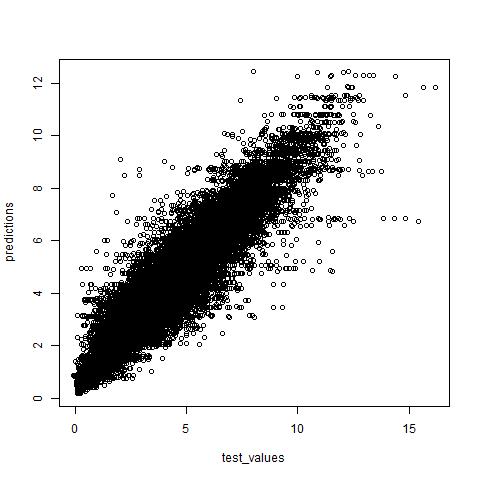

In [0]:
%%R
print(model2_scores)
plot(test_values,predictions)

In [0]:
%%R
# Fitting Model 2 (Main Environment-Pedigree Effects)
# (EA)

# A = A/mean(diag(A))
# L = t(chol(A))
# ZL = ZVAR%*%L

# ETA = list(ENV=list(X=ZE,model='BRR'),
#            PED=list(X=ZL,model='BRR'))
	
# fm2 = BGLR(y=y_train,ETA=ETA,saveAt='M2_',nIter=500,burnIn=200)


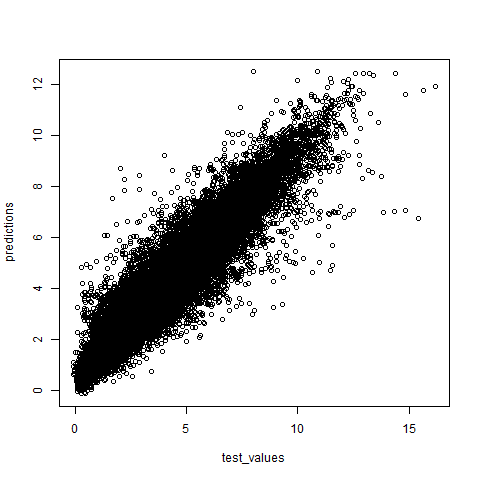

In [0]:
%%R
# predictions = fm2$yHat[-training.samples]
# test_values = Y$grain_yield[-training.samples]
# print(data.frame( R2 = R2(predictions, test_values),
#             RMSE = RMSE(predictions, test_values),
#             MAE = MAE(predictions, test_values)))

# plot(test_values,predictions)

In [0]:
%%R
# Fitting Model 3 (Main Environment-Pedigree-Environmental Covariate Effects)
# (EAW)

W = W/sqrt(ncol(W))

ETA = list(ENV=list(X=ZE,model='BRR'),
           PED=list(X=Z_star,model='BRR'),
           EC=list(X=W,model='BRR'))

fm3 = BGLR(y=y_train,ETA=ETA,saveAt='M3_',nIter=500,burnIn=200)


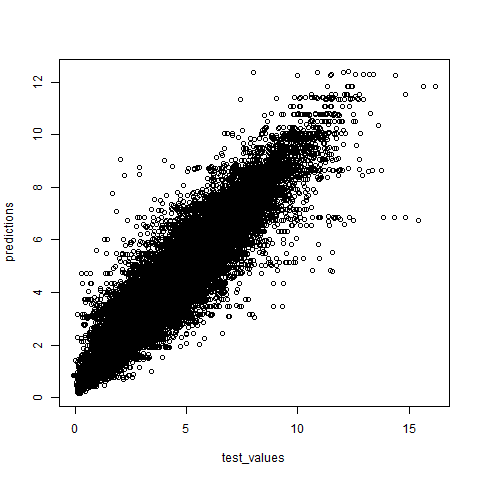

In [0]:
%%R
predictions = fm3$yHat[-training.samples]
test_values = Y$grain_yield[-training.samples]
model3_scores = data.frame(R2 = R2(predictions, test_values),
            RMSE = RMSE(predictions, test_values),
            MAE = MAE(predictions, test_values))
print(model3_scores)
plot(test_values,predictions)

In [0]:
%%R
# Fitting Model 4 (Main Environment-Pedigree-Environmental Covariate Effects 
# with Pedigree-Environmental Covariate Interaction)
# (EAW-AxW)

# Results in vector of size 157.4 Gb, need sufficient RAM to hold

ZAZ = tcrossprod(Z_star)

W = as.matrix(W)

WW = tcrossprod(W)



Error: cannot allocate vector of size 157.4 Gb


PermissionError: ignored

In [0]:

K = ZAZ*WW
diag(K) = diag(K)+1/200 
K = K/mean(diag(K))
L2 = t(chol(K))


In [0]:

ETA = list(ENV=list(X=ZE,model='BRR'),
           PED=list(X=ZL,model='BRR'),
           EC=list(X=W,model='BRR'),
           AxW=list(X=L2,model='BRR'))

fm4 = BGLR(y=y_train,ETA=ETA, saveAt='M4_',nIter=500,burnIn=200)

In [0]:
predictions = fm4$yHat[-training.samples]
test_values = Y$grain_yield[-training.samples]
print(data.frame( R2 = R2(predictions, test_values),
            RMSE = RMSE(predictions, test_values),
            MAE = MAE(predictions, test_values)))

plot(test_values,predictions)

In [0]:
%%R
# Fitting Model 5 (Main Environment-Pedigree-Environmental Covariate Effects 
# with Pedigree-Environmental Covariate Interaction and Pedigree-Environment Main Effects)
# (EAW-AxW-AxE)

ZZ = tcrossprod(ZE)
K = ZZ* ZAZ
diag(K) = diag(K)+1/200 
K = K/mean(diag(K))
L3 = t(chol(K))

ETA = list(ENV=list(X=ZE,model='BRR'),
           PED=list(X=ZL,model='BRR'),
           EC=list(X=W,model='BRR'),
           AxW=list(X=L2,model='BRR'),
           AxE=list(X=L3,model='BRR'))

fm5 = BGLR(y=y_train,ETA=ETA, saveAt='M5_',nIter=500,burnIn=200)

In [0]:
%%R
predictions = fm5$yHat[-training.samples]
test_values = Y$grain_yield[-training.samples]
print(data.frame( R2 = R2(predictions, test_values),
            RMSE = RMSE(predictions, test_values),
            MAE = MAE(predictions, test_values)))

plot(test_values,predictions)